# EMATM0044 Introduction to AI Coursework Part 1

## Question 1  


This dataset consists of the number of rental bikes out for rent at each hour (column Rented Bike count), together with other features such as the hour of the day, the date, humidity, and so on. ***Your task is to build a model to predict the number of rental bikes out at each hour, given the values of the other features of the dataset.***

Write the methods tried

### Load dataset

In [27]:
import numpy as np;
import pandas as pd;
import matplotlib;
import matplotlib.pyplot as plt;

Following results show that there is non null values.

In [28]:
data = pd.read_csv("coursework_other.csv", encoding='unicode_escape');
data.info(); # Check Non-Null Count and Dtype of each Column.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8760 non-null   object 
 1   Rented Bike Count          8760 non-null   int64  
 2   Hour                       8760 non-null   int64  
 3   Temperature(°C)            8760 non-null   float64
 4   Humidity(%)                8760 non-null   int64  
 5   Wind speed (m/s)           8760 non-null   float64
 6   Visibility (10m)           8760 non-null   int64  
 7   Dew point temperature(°C)  8760 non-null   float64
 8   Solar Radiation (MJ/m2)    8760 non-null   float64
 9   Rainfall(mm)               8760 non-null   float64
 10  Snowfall (cm)              8760 non-null   float64
 11  Seasons                    8760 non-null   object 
 12  Holiday                    8760 non-null   object 
 13  Functioning Day            8760 non-null   objec

### Data preprocessing

#### Extract Year, Month, Day

In [29]:
# Extract year, month, day from Date
year = data['Date'].apply(lambda x: int(x.split("/")[2]));
month = data['Date'].apply(lambda x: int(x.split("/")[1]));
day = data['Date'].apply(lambda x: int(x.split("/")[0]));

# Unique values of year, month, day
print("Year:", np.unique(year));
print("Month:", np.unique(month));
print("Day:", np.unique(day));

# Add new columns
# Here we do not drop Date immediately, because Date is used to split data
data['Year'], data['Month'], data['Day'] = year, month, day;

Year: [2017 2018]
Month: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Day: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]


#### Features selection

According to the real-life situation, the `Rented Bike Count` should be very time-related, which means during the functioning day and working hours the count number should be high. And we can also consider that there will be more rented bike count during summer and autumn. However, sometimes granularity like `Seasons` are too general and we may need to dig into more detailed granularity like `Month`, `Day` or other granularity like `Year`.  

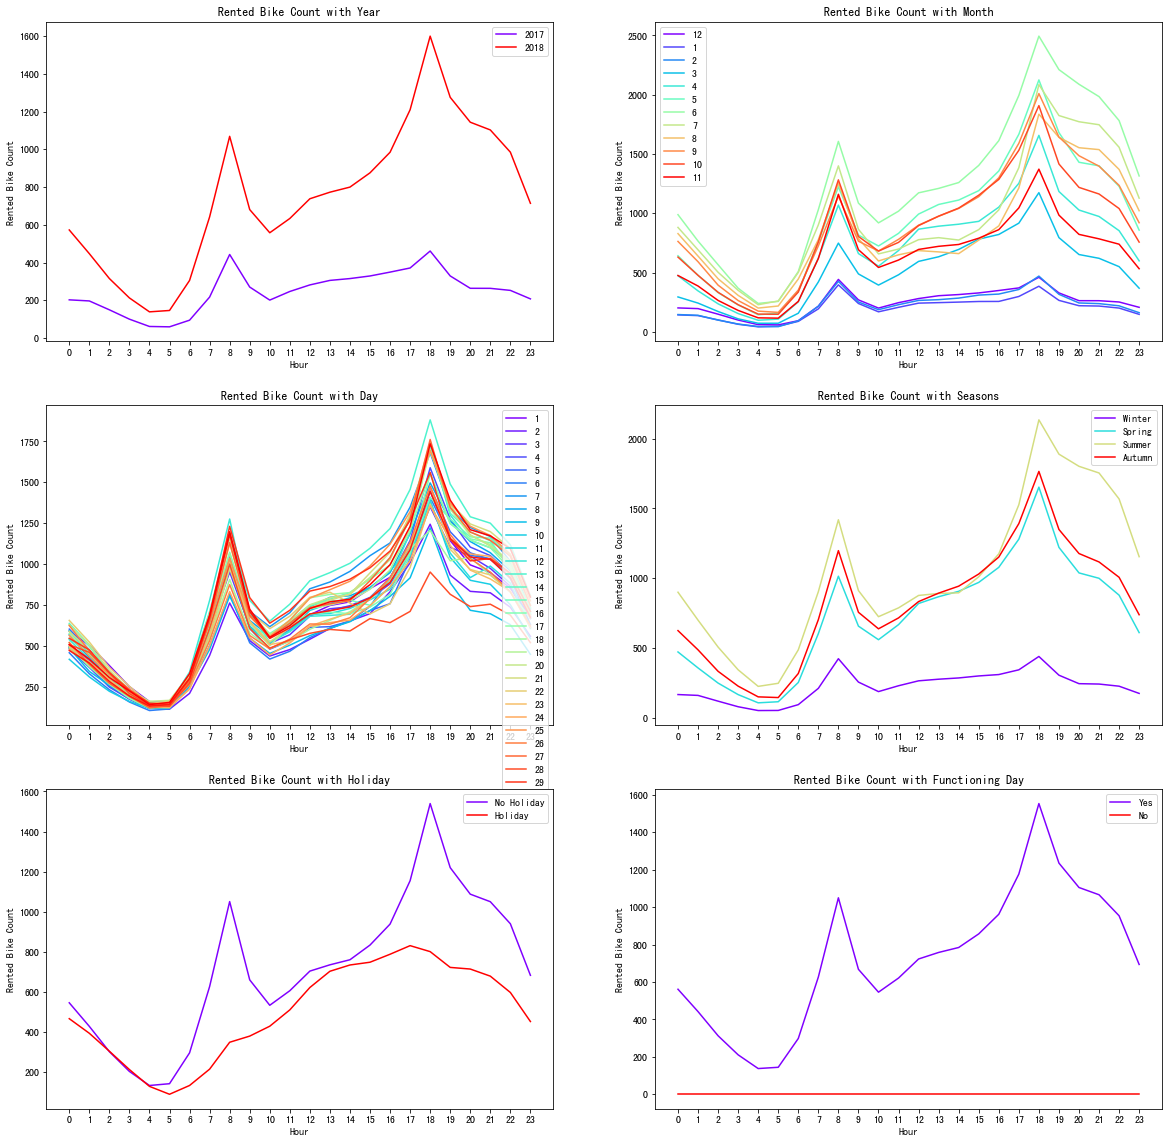

In [4]:
columns = ['Year', 'Month', 'Day', 'Seasons', 'Holiday', 'Functioning Day'];
f, axes = plt.subplots(len(columns)//2, 2, figsize=(20,20)); 
hours = data['Hour'].unique();

for i, column in enumerate(columns):
    group = data.groupby([column, 'Hour'])['Rented Bike Count'].mean().reset_index();
    unique_values = data[column].unique();
    colors = plt.cm.rainbow(np.linspace(0, 1, unique_values.size));
    axes[i//2, i%2].set_title("Rented Bike Count with "+column);

    for j, value in enumerate(unique_values):
        cnt = group[group[column]==value]['Rented Bike Count'].values;
        axes[i//2, i%2].plot(hours, cnt, label=value, c=colors[j]);

    axes[i//2, i%2].legend();
    axes[i//2, i%2].set_xticks(np.arange(0, 24, 1));
    axes[i//2, i%2].set_xlabel("Hour");
    axes[i//2, i%2].set_ylabel("Rented Bike Count");

The first plot below illustartes that `Year` has a great influence on the `Rented Bike Count`, however, after checking the data of year 2017 and 2018, we found all the data from 2017 is collected during December, which makes the mean value of `Rented Bike Count` so low, so `Year` cannot be used into training.

The second plot illustrates the number of `Rented Bike Count` every from month to month. So `Month` should be extract from the `Date` and treated as an important feature, it has a more detailed insight than the `Seaons`. To determine whether expand `Month` feature, we need to put it into different models to check whether it will have a better performance.

From the third plot, we noticed that `Rented Bike Count` doesn't have a strong relation with `Day`.

In [5]:
def mapCatToNum(data, columns):
    for column in columns:
        newcolumns = data[column];
        unique_values = data[column].unique();
        for i, value in enumerate(unique_values):
            newcolumns[newcolumns==value] = i;
        data[column] = newcolumns.astype('int32');

In [6]:
mapCatToNum(data, ['Seasons', 'Holiday', 'Functioning Day']);

/var/folders/yb/9xwj_fjx3q393m8tvyg624480000gn/T/ipykernel_39143/2787174582.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newcolumns[newcolumns==value] = i;


In [7]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]));
    ax.set_yticks(np.arange(data.shape[0]));
    ax.set_xticklabels(col_labels);
    ax.set_yticklabels(row_labels);

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [8]:
copy = data.copy();
copy.drop(columns=['Date', 'Year', 'Day'] , inplace=True);

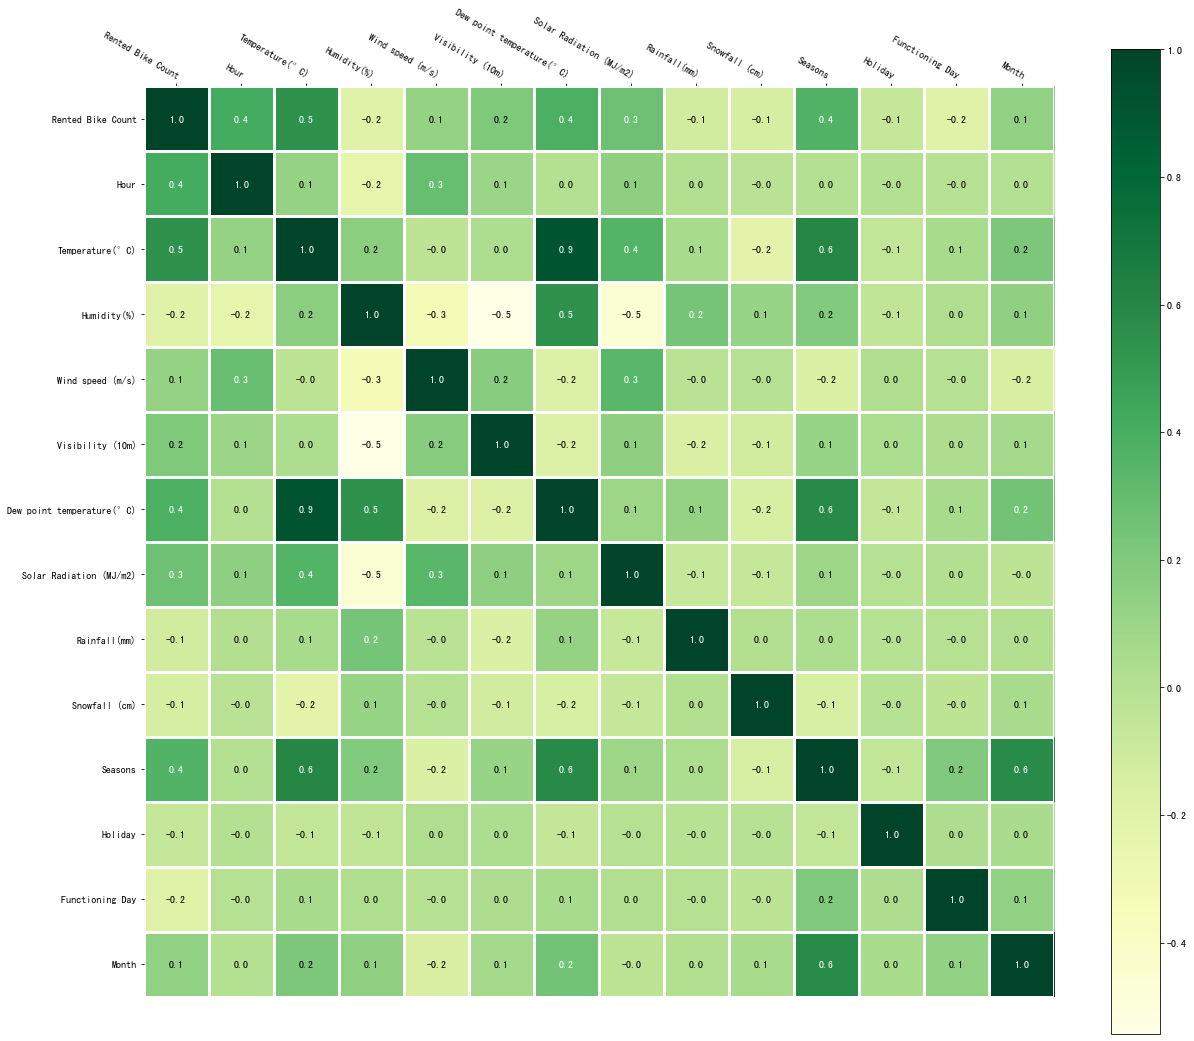

In [9]:
# Heatmap - Pearson
fig, ax = plt.subplots(figsize=(18, 15));
im, cbar = heatmap(copy.corr(), copy.columns.values, copy.columns.values, ax=ax, cmap="YlGn");
texts = annotate_heatmap(im, valfmt="{x:.1f}");
fig.tight_layout();
plt.show();

### Preprocessing - Dummy of Categorial data

Generally, for categorial data, we will take dummy of them.

In [11]:
data.drop(columns=['Year', 'Day'], inplace=True);

In [12]:
dummy_columns = data.columns[data.columns.isin(['Seasons', 'Holiday', 'Functioning Day', 'Hour', 'Month'])];
data = pd.get_dummies(data, columns=dummy_columns); # Encode categorical data.

In [13]:
# Normalizing.
for column in data.columns:
    if column != 'Date' and column != 'Rented Bike Count':
        min_v = data[column].min();
        max_v = data[column].max();
        data[column] = (data[column]-min_v)/max_v;

### Modeling

#### Split data into training, validation and test

The problem is set to predict the number of rent bikes in each hour, so we shall have enough data of each hour. Take this point into consideration, the idea is to split data by dates. If we shuffle the data and mix it up, we cannot ensure each hour takes up equal proportion. So, to get a hour-equally-distributed training, validation and testing data, we split the dataset by dates.

The following codes are wrapped data split by dates function for `train_test_split` and `KFold`.

In [41]:
from sklearn.model_selection import train_test_split;

def data_split_by_dates(data, test_size=.2, val_size=0, random_state=0, shuffle=True):
    # Split data by date to ensure hours are equally distributed (each set has sufficient data of each hour).
    dates = data['Date'].unique();
    dates_tr, dates_tst =  train_test_split(dates, test_size=test_size, random_state=random_state, shuffle=shuffle);
    if not val_size:
        data_tr = data[data['Date'].isin(dates_tr)]; # Data for training.
        data_tst = data[data['Date'].isin(dates_tst)]; # Data for testing.
        return data_tr, data_tst;
    else:
        dates_tr, dates_dev =  train_test_split(dates_tr, test_size=val_size/(1-test_size), random_state=random_state, shuffle=shuffle);
        data_tr = data[data['Date'].isin(dates_tr)]; # Data for training.
        data_val = data[data['Date'].isin(dates_dev)]; # Data for validation.
        data_tst = data[data['Date'].isin(dates_tst)]; # Data for testing.
        return data_tr, data_val, data_tst;

# Unit test
data_tr, data_tst = data_split_by_dates(data, test_size=.2);
assert(data_tr.shape[0] == data.shape[0]*.8);
assert(data_tst.shape[0] == data.shape[0]*.2);

In [42]:
data_tr['Hour'].value_counts()

0     292
4     292
19    292
15    292
11    292
7     292
3     292
22    292
18    292
14    292
10    292
6     292
2     292
21    292
17    292
13    292
9     292
5     292
1     292
20    292
16    292
12    292
8     292
23    292
Name: Hour, dtype: int64

In [15]:
from sklearn.model_selection import KFold;

def KFold_by_dates(data, n_splits=5, random_state=0, shuffle=True):
    dates = data['Date'].unique();
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle);
    iteration = [];

    for index_tr, index_tst in kf.split(dates):
        dates_tr, dates_val = dates[index_tr], dates[index_tst];
        data_tr = data[data['Date'].isin(dates_tr)].drop(columns=['Date']); # Data for training
        data_tst = data[data['Date'].isin(dates_val)].drop(columns=['Date']); # Data for testing
        Xtr, ytr = data_tr.iloc[:, 1:], data_tr.iloc[:, 0];
        Xval, yval = data_tst.iloc[:, 1:], data_tst.iloc[:, 0];
        iteration.append([Xtr, Xval, ytr, yval]);
    
    return iteration;

# Unit test
iteration = KFold_by_dates(data);
assert(len(iteration)==5);
assert(iteration[0][0].shape[0] == data.shape[0]*4/5);
assert(iteration[0][1].shape[0] == data.shape[0]/5);

#### Metrics

There are lots of metrics (or loss function) for regression problem and the most common used metric is `mean square error`.

In sklearn model, the built-in metric for regression model is called $R^2$ given by $(1 - \frac{u}{v})$ in which the `u` is the residual sum of squares $(y_{true} - y_{pred})^2.sum()$ and `v` is the total sum of squares $(y_{true} -y_{true}.mean())^2.sum()$.

Here we use both of these to compare the performance.

In [16]:
from sklearn.linear_model import Lasso, Ridge;
from sklearn.tree import DecisionTreeRegressor;
from sklearn.neighbors import KNeighborsRegressor;
from sklearn.metrics import mean_squared_error, r2_score;

In [19]:
# Split data into training and testing data, and testing data will never been used into model training
data_tr, data_tst = data_split_by_dates(data);
# Data by KFold
iteration = KFold_by_dates(data_tr);

data_tr.drop(columns=['Date'], inplace=True);
data_tst.drop(columns=['Date'], inplace=True);

X_train, y_train = data_tr.iloc[:, 1:], data_tr.iloc[:, 0];
X_test, y_test = data_tst.iloc[:, 1:], data_tst.iloc[:, 0];

/usr/local/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [16]:
# Split data by default
data_tr_default, data_tst_default = train_test_split(data, test_size=0.2, random_state=0, shuffle=True);

data_tr_default.drop(columns=['Date'], inplace=True);
data_tst_default.drop(columns=['Date'], inplace=True);

X_train_default, y_train_default = data_tr_default.iloc[:, 1:], data_tr_default.iloc[:, 0];
X_test_default, y_test_default = data_tst_default.iloc[:, 1:], data_tst_default.iloc[:, 0];

kf = KFold(5, random_state=0, shuffle=True);
iteration_default = [];
for train_index, val_index in kf.split(X_train_default):
    Xtr, Xval = X_train_default.iloc[train_index], X_train_default.iloc[val_index]
    ytr, yval = y_train_default.iloc[train_index], y_train_default.iloc[val_index]
    iteration_default.append([Xtr, Xval, ytr, yval]);

/usr/local/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


#### Baseline

Here we use sklearn DummyRegressor with `mean` as the baseline. And we use baseline to compare the performance between data split by date and by default.

In [17]:
from sklearn.dummy import DummyRegressor;

dummy_reg = DummyRegressor(strategy="mean");
dummy_reg.fit(X_train, y_train);
y_pred = dummy_reg.predict(X_test);

test_mse_baseline = mean_squared_error(y_test, y_pred);
test_r2_baseline = r2_score(y_test, y_pred);

print("Performance of Dummy, data split by dates")
print("R2:", test_r2_baseline);
print("MSE:", test_mse_baseline);

dummy_reg.fit(X_train_default, y_train_default);
y_pred = dummy_reg.predict(X_test_default);

test_mse_baseline_default = mean_squared_error(y_test_default, y_pred);
test_r2_baseline_default = r2_score(y_test_default, y_pred);

print("\nPerformance of Dummy, data split by default")
print("R2:", test_r2_baseline_default);
print("MSE:", test_mse_baseline_default);

Performance of Dummy, data split by dates
R2: -0.02096051173293967
MSE: 412658.52763738466

Performance of Dummy, data split by default
R2: -0.0011246125352522007
MSE: 418993.2642036181


#### Linear regression

In [18]:
alphas = np.linspace(0, 1, 50);
train_mse = [[] for _ in range(len(alphas))];
train_r2 = [[] for _ in range(len(alphas))];
val_mse = [[] for _ in range(len(alphas))];
val_r2 = [[] for _ in range(len(alphas))];

for i, alpha in enumerate(alphas):
    reg = Ridge(alpha=alpha, random_state=0);
    train_mse_tmp = [];
    train_r2_tmp = [];
    val_mse_tmp = [];
    val_r2_tmp = [];
    for Xtr, Xval, ytr, yval in iteration:
        reg.fit(Xtr, ytr);
        ytr_pred = reg.predict(Xtr);
        yval_pred = reg.predict(Xval);
        train_mse_tmp.append(mean_squared_error(ytr, ytr_pred));
        train_r2_tmp.append(r2_score(ytr, ytr_pred));
        val_mse_tmp.append(mean_squared_error(yval, yval_pred));
        val_r2_tmp.append(r2_score(yval, yval_pred));
    train_mse[i] = train_mse_tmp;
    train_r2[i] = train_r2_tmp;
    val_mse[i] = val_mse_tmp;
    val_r2[i] = val_r2_tmp;

train_mse_avg_lg = np.mean(train_mse, axis=1);
train_r2_avg_lg = np.mean(train_r2, axis=1);
val_mse_avg_lg = np.mean(val_mse, axis=1);
val_r2_avg_lg = np.mean(val_r2, axis=1);

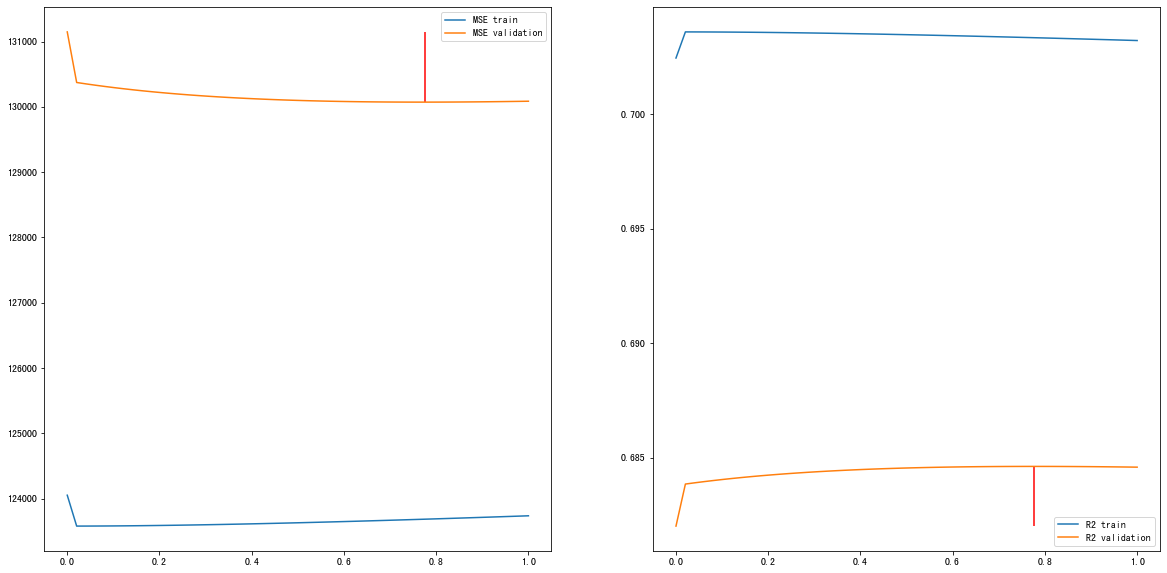

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10));
ax1.plot(alphas, train_mse_avg_lg, label="MSE train");
ax1.plot(alphas, val_mse_avg_lg, label="MSE validation");
ax1.vlines(alphas[val_mse_avg_lg == val_mse_avg_lg.min()], val_mse_avg_lg.min(), val_mse_avg_lg.max(), 'red');
ax1.legend();

ax2.plot(alphas, train_r2_avg_lg, label="R2 train");
ax2.plot(alphas, val_r2_avg_lg, label="R2 validation");
ax2.vlines(alphas[val_r2_avg_lg == val_r2_avg_lg.max()], val_r2_avg_lg.min(), val_r2_avg_lg.max(), 'red');
ax2.legend();

In [20]:
print("Minimum MSE of validation data:", val_mse_avg_lg.min());
print("Maximum R2 of validation data:", val_r2_avg_lg.max());
print("Optimal value of hyper parameter:", alphas[val_r2_avg_lg==val_r2_avg_lg.max()]);

Minimum MSE of validation data: 130072.25541773325
Maximum R2 of validation data: 0.6846196683814891
Optimal value of hyper parameter: [0.7755102]


In [21]:
ridge = Ridge(alpha=0.7755102, random_state=0);
ridge.fit(X_train, y_train);
y_pred = ridge.predict(X_test);

test_mse_ridge = mean_squared_error(y_test, y_pred);
test_r2_ridge = r2_score(y_test, y_pred);

print("R2:", test_r2_ridge);
print("MSE:", test_mse_ridge);

R2: 0.6659587571851131
MSE: 135014.98426827544


#### KNN

In [22]:
n_neighbors = np.arange(1, 20, 1);
train_mse = [[] for _ in range(len(n_neighbors))];
train_r2 = [[] for _ in range(len(n_neighbors))];
val_mse = [[] for _ in range(len(n_neighbors))];
val_r2 = [[] for _ in range(len(n_neighbors))];

for i, n_neighbor in enumerate(n_neighbors):
    reg = KNeighborsRegressor(n_neighbors=n_neighbor);
    train_mse_tmp = [];
    train_r2_tmp = [];
    val_mse_tmp = [];
    val_r2_tmp = [];
    for Xtr, Xval, ytr, yval in iteration:
        reg.fit(Xtr, ytr);
        ytr_pred = reg.predict(Xtr);
        yval_pred = reg.predict(Xval);
        train_mse_tmp.append(mean_squared_error(ytr, ytr_pred));
        train_r2_tmp.append(r2_score(ytr, ytr_pred));
        val_mse_tmp.append(mean_squared_error(yval, yval_pred));
        val_r2_tmp.append(r2_score(yval, yval_pred));
    train_mse[i] = train_mse_tmp;
    train_r2[i] = train_r2_tmp;
    val_mse[i] = val_mse_tmp;
    val_r2[i] = val_r2_tmp;

train_mse_avg_knn = np.mean(train_mse, axis=1);
train_r2_avg_knn = np.mean(train_r2, axis=1);
val_mse_avg_knn = np.mean(val_mse, axis=1);
val_r2_avg_knn = np.mean(val_r2, axis=1);

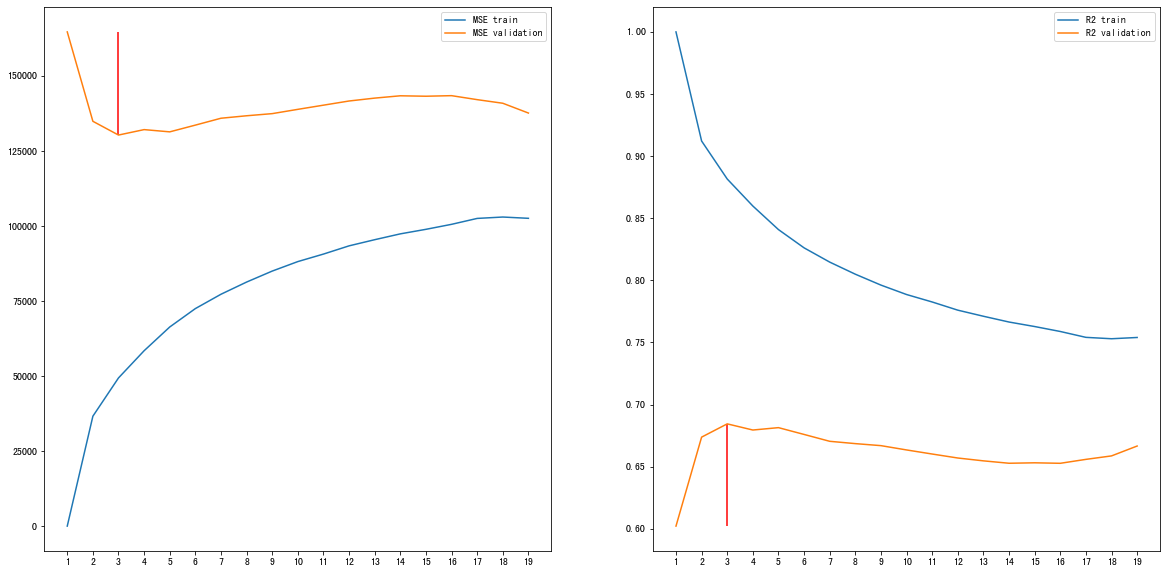

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10));
ax1.plot(n_neighbors, train_mse_avg_knn, label="MSE train");
ax1.plot(n_neighbors, val_mse_avg_knn, label="MSE validation");
ax1.set_xticks(n_neighbors);
ax1.vlines(n_neighbors[val_mse_avg_knn == val_mse_avg_knn.min()], val_mse_avg_knn.min(), val_mse_avg_knn.max(), 'red');
ax1.legend();

ax2.plot(n_neighbors, train_r2_avg_knn, label="R2 train");
ax2.plot(n_neighbors, val_r2_avg_knn, label="R2 validation");
ax2.set_xticks(n_neighbors);
ax2.vlines(n_neighbors[val_r2_avg_knn == val_r2_avg_knn.max()], val_r2_avg_knn.min(), val_r2_avg_knn.max(), 'red');
ax2.legend();

In [24]:
print("Minimum MSE of validation data:", val_mse_avg_knn.min());
print("Maximum R2 of validation data:", val_r2_avg_knn.max());
print("Optimal value of hyper parameter:", n_neighbors[val_r2_avg_knn==val_r2_avg_knn.max()]);

Minimum MSE of validation data: 130315.65944595968
Maximum R2 of validation data: 0.6844312010852557
Optimal value of hyper parameter: [3]


In [25]:
knn = KNeighborsRegressor(n_neighbors=3);
knn.fit(X_train, y_train);
y_pred = knn.predict(X_test);

test_mse_knn = mean_squared_error(y_test, y_pred);
test_r2_knn = r2_score(y_test, y_pred);

print("R2:", test_r2_knn);
print("MSE:", test_mse_knn);

R2: 0.6117482720649353
MSE: 156926.13432267887


#### Decision Tree

Hyperparameter: max_depth

In [26]:
max_depths = np.arange(5, 50, 1);
train_mse = [[] for _ in range(len(max_depths))];
train_r2 = [[] for _ in range(len(max_depths))];
val_mse = [[] for _ in range(len(max_depths))];
val_r2 = [[] for _ in range(len(max_depths))];

for i, max_depth in enumerate(max_depths):
    reg = DecisionTreeRegressor(max_depth=max_depth);
    train_mse_tmp = [];
    train_r2_tmp = [];
    val_mse_tmp = [];
    val_r2_tmp = [];
    for Xtr, Xval, ytr, yval in iteration:
        reg.fit(Xtr, ytr);
        ytr_pred = reg.predict(Xtr);
        yval_pred = reg.predict(Xval);
        train_mse_tmp.append(mean_squared_error(ytr, ytr_pred));
        train_r2_tmp.append(r2_score(ytr, ytr_pred));
        val_mse_tmp.append(mean_squared_error(yval, yval_pred));
        val_r2_tmp.append(r2_score(yval, yval_pred));
    train_mse[i] = train_mse_tmp;
    train_r2[i] = train_r2_tmp;
    val_mse[i] = val_mse_tmp;
    val_r2[i] = val_r2_tmp;

train_mse_avg_tree = np.mean(train_mse, axis=1);
train_r2_avg_tree = np.mean(train_r2, axis=1);
val_mse_avg_tree = np.mean(val_mse, axis=1);
val_r2_avg_tree = np.mean(val_r2, axis=1);

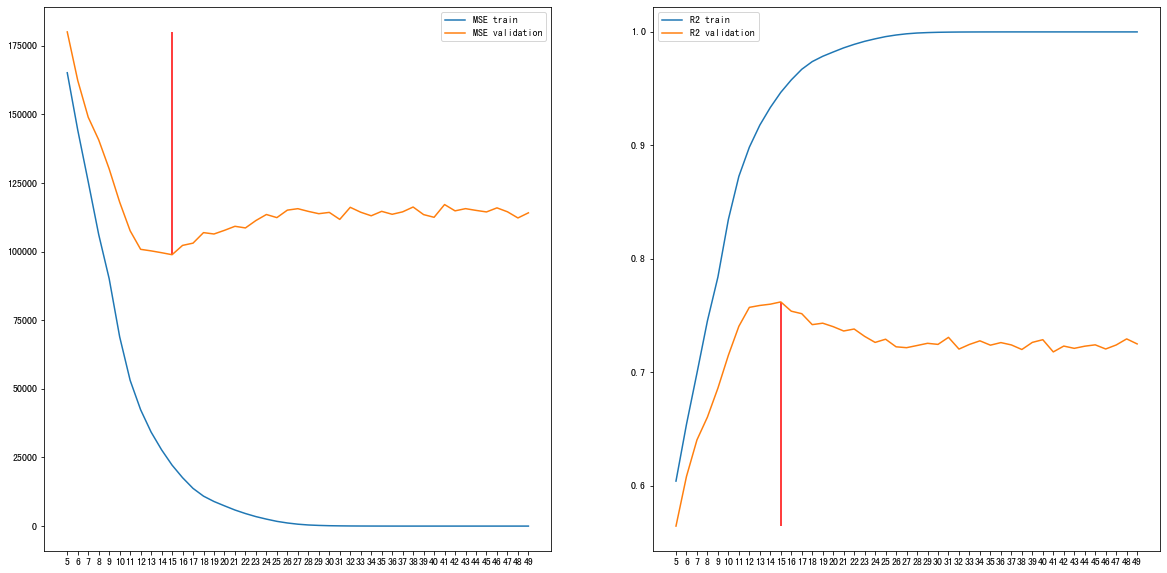

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10));
ax1.plot(max_depths, train_mse_avg_tree, label="MSE train");
ax1.plot(max_depths, val_mse_avg_tree, label="MSE validation");
ax1.set_xticks(max_depths);
ax1.vlines(max_depths[val_mse_avg_tree == val_mse_avg_tree.min()], val_mse_avg_tree.min(), val_mse_avg_tree.max(), 'red');
ax1.legend();

ax2.plot(max_depths, train_r2_avg_tree, label="R2 train");
ax2.plot(max_depths, val_r2_avg_tree, label="R2 validation");
ax2.set_xticks(max_depths);
ax2.vlines(max_depths[val_r2_avg_tree == val_r2_avg_tree.max()], val_r2_avg_tree.min(), val_r2_avg_tree.max(), 'red');
ax2.legend();

In [28]:
print("Minimum MSE of validation data:", val_mse_avg_tree.min());
print("Maximum R2 of validation data:", val_r2_avg_tree.max());
print("Optimal value of hyper parameter:", max_depths[val_r2_avg_tree==val_r2_avg_tree.max()]);

Minimum MSE of validation data: 98890.94549051888
Maximum R2 of validation data: 0.7619092728409811
Optimal value of hyper parameter: [15]


In [29]:
# tree = DecisionTreeRegressor(max_depth=15, random_state=0);
# tree.fit(X_train, y_train);
# y_pred = tree.predict(X_test);

# test_mse_tree = mean_squared_error(y_test, y_pred);
# test_r2_tree = r2_score(y_test, y_pred);

# print("R2:", test_r2_tree);
# print("MSE:", test_mse_tree);

Hyperparameter: min_samples_leaf

In [30]:
min_samples_leafs = np.arange(1, 25, 1);

train_mse = [[] for _ in range(len(min_samples_leafs))];
train_r2 = [[] for _ in range(len(min_samples_leafs))];
val_mse = [[] for _ in range(len(min_samples_leafs))];
val_r2 = [[] for _ in range(len(min_samples_leafs))];

for i, min_samples_leaf in enumerate(min_samples_leafs):
    reg = DecisionTreeRegressor(min_samples_leaf=min_samples_leaf, random_state=0);
    train_mse_tmp = [];
    train_r2_tmp = [];
    val_mse_tmp = [];
    val_r2_tmp = [];
    for Xtr, Xval, ytr, yval in iteration:
        reg.fit(Xtr, ytr);
        ytr_pred = reg.predict(Xtr);
        yval_pred = reg.predict(Xval);
        train_mse_tmp.append(mean_squared_error(ytr, ytr_pred));
        train_r2_tmp.append(r2_score(ytr, ytr_pred));
        val_mse_tmp.append(mean_squared_error(yval, yval_pred));
        val_r2_tmp.append(r2_score(yval, yval_pred));
    train_mse[i] = train_mse_tmp;
    train_r2[i] = train_r2_tmp;
    val_mse[i] = val_mse_tmp;
    val_r2[i] = val_r2_tmp;

train_mse_avg = np.mean(train_mse, axis=1);
train_r2_avg = np.mean(train_r2, axis=1);
val_mse_avg = np.mean(val_mse, axis=1);
val_r2_avg = np.mean(val_r2, axis=1);

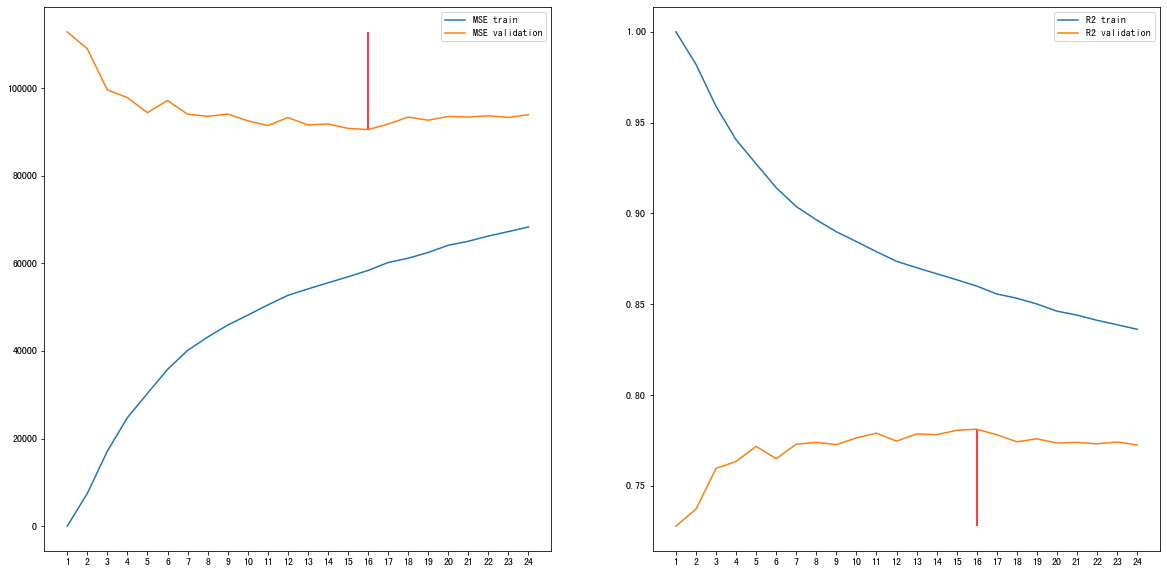

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10));
ax1.plot(min_samples_leafs, train_mse_avg, label="MSE train");
ax1.plot(min_samples_leafs, val_mse_avg, label="MSE validation");
ax1.set_xticks(min_samples_leafs);
ax1.vlines(min_samples_leafs[val_mse_avg == val_mse_avg.min()], val_mse_avg.min(), val_mse_avg.max(), 'red');
ax1.legend();

ax2.plot(min_samples_leafs, train_r2_avg, label="R2 train");
ax2.plot(min_samples_leafs, val_r2_avg, label="R2 validation");
ax2.set_xticks(min_samples_leafs);
ax2.vlines(min_samples_leafs[val_r2_avg == val_r2_avg.max()], val_r2_avg.min(), val_r2_avg.max(), 'red');
ax2.legend();

In [32]:
print("Minimum MSE of validation data:", val_mse_avg.min());
print("Maximum R2 of validation data:", val_r2_avg.max());
print("Optimal value of hyper parameter:", min_samples_leafs[val_r2_avg==val_r2_avg.max()]);

Minimum MSE of validation data: 90558.51046436877
Maximum R2 of validation data: 0.7812129893568353
Optimal value of hyper parameter: [16]


In [33]:
# tree = DecisionTreeRegressor(min_samples_leaf=16, random_state=0);
# tree.fit(X_train, y_train);
# y_pred = tree.predict(X_test);

# tree_mse = mean_squared_error(y_test, y_pred);
# tree_r2 = r2_score(y_test, y_pred);

# print("R2:", tree_r2);
# print("MSE:", tree_mse);

Hyperparameter: min_samples_splits

In [34]:
min_samples_splits = np.arange(30, 100, 1);

train_mse = [[] for _ in range(len(min_samples_splits))];
train_r2 = [[] for _ in range(len(min_samples_splits))];
val_mse = [[] for _ in range(len(min_samples_splits))];
val_r2 = [[] for _ in range(len(min_samples_splits))];

for i, min_samples_split in enumerate(min_samples_splits):
    reg = DecisionTreeRegressor(min_samples_split=min_samples_split, max_depth=15, random_state=0);
    train_mse_tmp = [];
    train_r2_tmp = [];
    val_mse_tmp = [];
    val_r2_tmp = [];
    for Xtr, Xval, ytr, yval in iteration:
        reg.fit(Xtr, ytr);
        ytr_pred = reg.predict(Xtr);
        yval_pred = reg.predict(Xval);
        train_mse_tmp.append(mean_squared_error(ytr, ytr_pred));
        train_r2_tmp.append(r2_score(ytr, ytr_pred));
        val_mse_tmp.append(mean_squared_error(yval, yval_pred));
        val_r2_tmp.append(r2_score(yval, yval_pred));
    train_mse[i] = train_mse_tmp;
    train_r2[i] = train_r2_tmp;
    val_mse[i] = val_mse_tmp;
    val_r2[i] = val_r2_tmp;

In [35]:
train_mse_avg = np.mean(train_mse, axis=1);
train_r2_avg = np.mean(train_r2, axis=1);
val_mse_avg = np.mean(val_mse, axis=1);
val_r2_avg = np.mean(val_r2, axis=1);

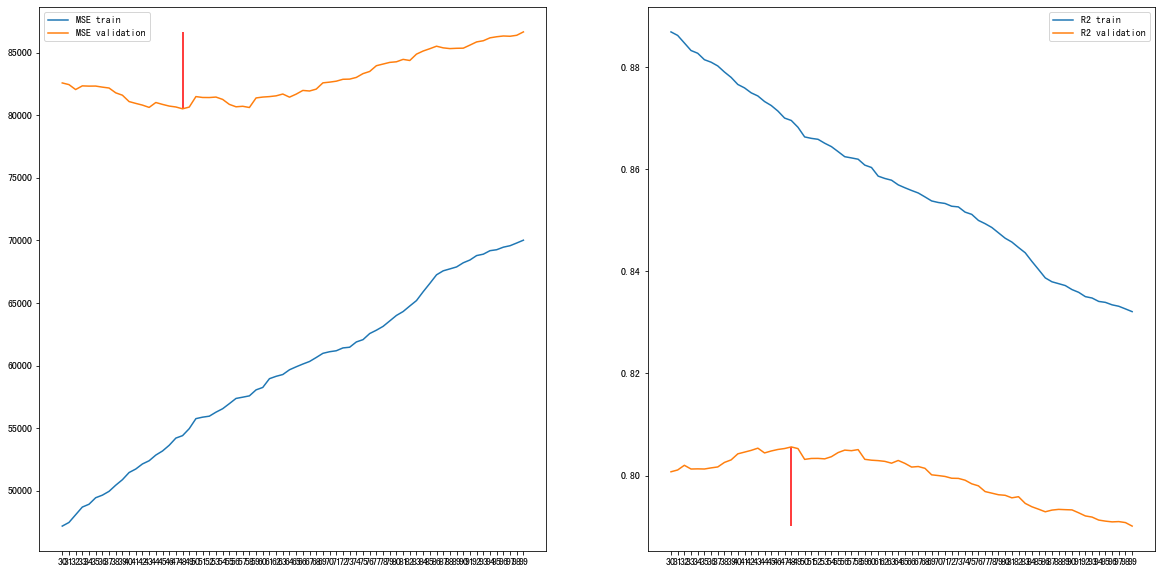

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10));
ax1.plot(min_samples_splits, train_mse_avg, label="MSE train");
ax1.plot(min_samples_splits, val_mse_avg, label="MSE validation");
ax1.set_xticks(min_samples_splits);
ax1.vlines(min_samples_splits[val_mse_avg == val_mse_avg.min()], val_mse_avg.min(), val_mse_avg.max(), 'red');
ax1.legend();

ax2.plot(min_samples_splits, train_r2_avg, label="R2 train");
ax2.plot(min_samples_splits, val_r2_avg, label="R2 validation");
ax2.set_xticks(min_samples_splits);
ax2.vlines(min_samples_splits[val_r2_avg == val_r2_avg.max()], val_r2_avg.min(), val_r2_avg.max(), 'red');
ax2.legend();

In [37]:
print("Minimum MSE of validation data:", val_mse_avg.min());
print("Maximum R2 of validation data:", val_r2_avg.max());
print("Optimal value of hyper parameter:", min_samples_splits[val_r2_avg==val_r2_avg.max()]);

Minimum MSE of validation data: 80511.8367563462
Maximum R2 of validation data: 0.8055987906037281
Optimal value of hyper parameter: [48]


In [40]:
tree = DecisionTreeRegressor(min_samples_split=48, random_state=0);
tree.fit(X_train, y_train);
y_pred = tree.predict(X_test);

test_mse_tree = mean_squared_error(y_test, y_pred);
test_r2_tree = r2_score(y_test, y_pred);

print("R2:", test_r2_tree);
print("MSE:", test_mse_tree);

R2: 0.7767493300515153
MSE: 90234.92260110017


In [46]:
print("R2 scores on testing data");
print("Baseline:\t", test_r2_baseline)
print("Ridge Linear Regression:\t", test_r2_ridge);
print("K-nearest Neighbors Regressor:\t", test_r2_knn);
print("Decision Tree Regressor:\t", test_r2_tree);

print("\nMSE scores on testing data");
print("Baseline:\t", test_mse_baseline)
print("Ridge Linear Regression:\t", test_mse_ridge);
print("K-nearest Neighbors Regressor:\t", test_mse_knn);
print("Decision Tree Regressor:\t", test_mse_tree);

R2 scores on testing data
Baseline:	 -0.02096051173293967
Ridge Linear Regression:	 0.6659587571851131
K-nearest Neighbors Regressor:	 0.6117482720649353
Decision Tree Regressor:	 0.7767493300515153

MSE scores on testing data
Baseline:	 412658.52763738466
Ridge Linear Regression:	 135014.98426827544
K-nearest Neighbors Regressor:	 156926.13432267887
Decision Tree Regressor:	 90234.92260110017
